## Analysis of the labels from Google Cloud

In [11]:
from google.cloud import firestore
from google.cloud import storage
from tqdm import tqdm
from pathlib import Path
import json 
from geopy import distance
from collections import Counter
import geopandas
import pandas as pd
import numpy as np
import contextily as cx
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 200
from datetime import datetime
from scipy.spatial import cKDTree
import yaml
import random
# new library
import reverse_geocoder as rg

#### Initialize Connection to gcloud

In [2]:
# Initialize connections to cloud storage and database
client = storage.Client()
db = firestore.Client()
gcloud_labeling_bucket_str = 'street2sat-gcloud-labeling'
coll = db.collection("street2sat")

#### Obtain all jsonl files

In [87]:
jsonl_blobs = [file for file in client.list_blobs(gcloud_labeling_bucket_str) if file.name.endswith(".jsonl")]

print(f"Found {len(jsonl_blobs)} jsonl files in the bucket.")

Found 5 jsonl files in the bucket.


Iterates through the jsonl files and creates two dataframes: one with all the images, and another with all the bounding boxes using the path as a foreign key to correspond to the image dataframe. 

In [88]:
def get_image_and_bbox_df(blobs: list):
    images = []
    locations = []
    bounding_boxes = []
    for blob in blobs:
        str_rep = blob.download_as_string()
        for image_labels in tqdm(str_rep.splitlines()):
            # contains all the bounding box info and image path
            info_image = json.loads(image_labels)
            image_path = info_image['imageGcsUri']
            bounding_box_info = info_image['boundingBoxAnnotations']
            for b in bounding_box_info: 
                b['path'] = image_path
            # obtain image location from database and convert to tuple
            query = coll.where("input_img", "==", image_path).limit(1).get()
            loc = query[0].to_dict()['coord']
            loc = tuple(loc)
            if (loc[0] == None or loc[1] == None):
                # dont add image if no location is available 
                continue 
            locations.append(loc)
            images.append(image_path)
            bounding_boxes.extend(bounding_box_info)
    results = rg.search(locations)
    assert len(results) == len(images), "Number of locations found is != to number of images."
    df = pd.DataFrame(results)
    df['path'] = images
    df['lat'] = [coord[0] for coord in locations]
    df['lon'] = [coord[1] for coord in locations]
    df_bounding_boxes = pd.DataFrame(bounding_boxes)
    return df, df_bounding_boxes

image_info_df,bounding_box_df = get_image_and_bbox_df(jsonl_blobs)



100%|██████████| 99/99 [00:02<00:00, 46.57it/s]


In [89]:
image_info_df.head()

,lat,lon,name,admin1,admin2,cc,path
0,43.141348,-92.810015,Osage,Iowa,Mitchell County,US,gs://street2sat-uploaded/USA/2021-08-20-croptour/177GOPRO/G0394959.JPG
1,0.519084,32.636300,Bweyogerere,Central Region,Wakiso District,UG,gs://street2sat-uploaded/Uganda/2021-06-17_NACCRI-Catherine/stereo2/123GOPRO/G0181228.JPG
2,0.527763,32.623844,Bweyogerere,Central Region,Wakiso District,UG,gs://street2sat-uploaded/Uganda/2021-06-17_NACCRI-Kenan-Helmet/100GOPRO/G0017185.JPG
3,2.493243,31.875582,Nwoya,Northern Region,Nwoya District,UG,gs://street2sat-uploaded/Uganda/2021-06-29_Olwiyo_Hannah_left/2021-06-29_Olwiyo_Hannah_left/101GOPRO/G0018044.JPG
4,2.546518,31.897053,Nwoya,Northern Region,Nwoya District,UG,gs://street2sat-uploaded/Uganda/2021-06-29_Olwiyo_Catherine_left/2021-06-29_Olwiyo_Catherine_left/115GOPRO/GPAN0098.JPG


In [90]:
bounding_box_df.head()

,displayName,xMin,xMax,yMin,yMax,annotationResourceLabels,path
0,maize,0.305601,0.399506,0.372119,0.809001,{'aiplatform.googleapis.com/annotation_set_name': '7482370141062168576'},gs://street2sat-uploaded/Uganda/2021-06-17_NACCRI-Catherine/stereo2/123GOPRO/G0181228.JPG
1,maize,0.456343,0.565074,0.339188,0.788145,{'aiplatform.googleapis.com/annotation_set_name': '7482370141062168576'},gs://street2sat-uploaded/Uganda/2021-06-17_NACCRI-Catherine/stereo2/123GOPRO/G0181228.JPG
2,maize,0.789951,0.900329,0.358946,0.989023,{'aiplatform.googleapis.com/annotation_set_name': '7482370141062168576'},gs://street2sat-uploaded/Uganda/2021-06-17_NACCRI-Catherine/stereo2/123GOPRO/G0181228.JPG
3,maize,0.906919,0.986820,0.431394,0.727772,{'aiplatform.googleapis.com/annotation_set_name': '7482370141062168576'},gs://street2sat-uploaded/Uganda/2021-06-17_NACCRI-Catherine/stereo2/123GOPRO/G0181228.JPG
4,maize,0.098847,0.194399,0.345774,0.818880,{'aiplatform.googleapis.com/annotation_set_name': '7482370141062168576'},gs://street2sat-uploaded/Uganda/2021-06-17_NACCRI-Catherine/stereo2/123GOPRO/G0181228.JPG


In [91]:
vc = image_info_df['cc'].value_counts()
countries = vc.keys()
print(vc)

UG    264
KE    119
US     93
Name: cc, dtype: int64


Splits the data by each country randomly. 

In [116]:
train_set = pd.DataFrame()
val_set = pd.DataFrame()
for country in countries:
    train, test = train_test_split(image_info_df[image_info_df['cc'] == country], test_size=0.2, shuffle = True)
    train_set = train_set.append(train)
    val_set = val_set.append(test)

train_set = train_set.sample(frac = 1)
val_set = val_set.sample(frac = 1)

 If there are points in the validation set that are close to any in the train set, then put them both in the train set

In [113]:
'Returns distance and name of each neighbor in gdB from each point in gdA using a kd tree'
def ckdnearest(gdA, gdB):
    
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf


'filters on closeby points and returns the new datasets'
random.seed(10)
def filter_closeby_points(train_set, val_set): 

    train_set_g = geopandas.GeoDataFrame(train_set.copy(), geometry=geopandas.points_from_xy(train_set.lon, train_set.lat, crs='EPSG:4326'))
    val_set_g = geopandas.GeoDataFrame(val_set.copy(), geometry=geopandas.points_from_xy(val_set.lon, val_set.lat, crs='EPSG:4326'))

    val_set_g.rename(columns = {'path':'val_path'}, inplace = True)
    train_set_g.rename(columns = {'path':'train_path'}, inplace = True)


    res = ckdnearest(val_set_g, train_set_g)


    print('Found {} closeby points.'.format(len(res[res['dist'] < .001])))

    # add images that are too close to each other to the same set randomly
    old_val_len = len(val_set)
    old_train_len = len(train_set)

    for i,r in res[res['dist'] < .001].iterrows():
        val_row = val_set[val_set['path'] == r['val_path']]
        train_row = train_set[train_set['path'] == r['train_path']]
        
        which = random.choice(['train', 'val'])
        if which == 'train':
            val_set = val_set.drop(val_row.index)
            train_set = pd.concat([train_set, val_row])
        elif which == 'val':
            train_set = train_set.drop(train_row.index)
            val_set = pd.concat([val_set, train_row])
        
        assert old_train_len - len(train_set) == len(val_set) - old_val_len, 'lengths are incorrect'

    
    

    return train_set, val_set, len(res[res['dist'] < .001])


Run until 0 closeby points are found. 

In [118]:
closeby = -1
while closeby != 0:
    train_set, val_set, closeby = filter_closeby_points(train_set, val_set)




Found 8 closeby points.
Found 2 closeby points.
Found 2 closeby points.
Found 2 closeby points.
Found 4 closeby points.
Found 4 closeby points.
Found 4 closeby points.
Found 3 closeby points.
Found 0 closeby points.


In [119]:
train_set

,lat,lon,name,admin1,admin2,cc,path
16,2.565602,31.909522,Nwoya,Northern Region,Nwoya District,UG,gs://street2sat-uploaded/Uganda/2021-06-29_Olwiyo_Catherine_left/113GOPRO/GPAM9776.JPG
154,-0.314295,34.333900,Homa Bay,Homa Bay,,KE,gs://street2sat-uploaded/KENYA/2021_07_21_T2/104GOPRO/GPEM4976.JPG
211,-1.096648,35.927507,Narok,Narok,,KE,gs://street2sat-uploaded/KENYA/2021-08-04-T1/GPAS9205.JPG
207,0.043933,34.685936,Yala,Siaya,,KE,gs://street2sat-uploaded/KENYA/2021_07_17_T2/103GOPRO/GPES7872.JPG
276,0.311213,30.195515,Kasese,Western Region,Kasese District,UG,gs://street2sat-uploaded/Uganda/2021-06-24_Kasese_Catherine_left/109GOPRO/G0034366.JPG
...,...,...,...,...,...,...,...
182,41.117705,-84.495900,Paulding,Ohio,Paulding County,US,gs://street2sat-uploaded/USA/2021-08-20-croptour/102GOPRO/G0015832.JPG
188,41.117720,-84.495874,Paulding,Ohio,Paulding County,US,gs://street2sat-uploaded/USA/2021-08-20-croptour/102GOPRO/G0016076.JPG
371,41.117732,-84.495898,Paulding,Ohio,Paulding County,US,gs://street2sat-uploaded/USA/2021-08-20-croptour/102GOPRO/G0015576.JPG
208,41.117697,-84.495927,Paulding,Ohio,Paulding County,US,gs://street2sat-uploaded/USA/2021-08-20-croptour/103GOPRO/G0016913.JPG


Helper function to visualize and analyze labels

In [120]:
def visualize_labels(labels_df, bb_dataframe):
    comb_df = pd.merge(labels_df, bb_dataframe, how = 'inner', on = 'path')
    print('{} images found.'.format(len(labels_df)))
    print('{} labels found.'.format(len(comb_df)))
    print(comb_df['displayName'].value_counts())

    gdf = geopandas.GeoDataFrame(comb_df, geometry=geopandas.points_from_xy(comb_df.lon, comb_df.lat, crs='EPSG:4326'))
    
    ax = gdf.to_crs('EPSG:3857').plot(
        figsize=(10, 30), 
        marker='o', 
        column='displayName', 
        categorical=True,
        markersize=15,
        cmap = 'tab10',
        legend=True
    )
    ax.set_title("Label Locations")
    return cx.add_basemap(ax, source = cx.providers.OpenStreetMap.Mapnik)

    

# visualize_labels(train_set)


### Visualize labels
The labels can be visualized by using the helper function above. Either the train_set or val_set can be filtered by country. Use the cc parameter as shown below and use 'KE' for Kenya, 'UG' for Uganda, or 'US' for USA. 

383 images found.
804 labels found.
maize        640
banana        83
sugarcane     29
soybean       27
cassava       10
millet         7
coffee         5
rice           3
Name: displayName, dtype: int64


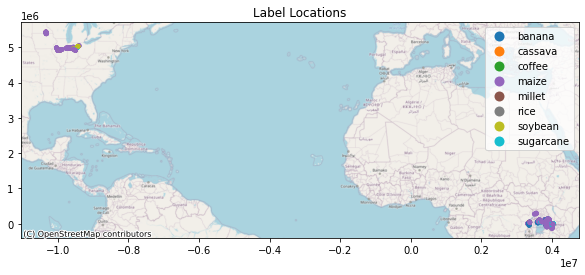

In [121]:
# visualize_labels(train_set[train_set['cc'] == 'UG'], bounding_box_df)
visualize_labels(train_set, bounding_box_df)

In [122]:
classes_dict = {}
with open('../street2sat_utils/crop_info/classes.txt') as classes_file: 
    for i, line in enumerate(classes_file):
        classes_dict[line.strip()] = i
classes_dict

{'tobacco': 0,
 'coffee': 1,
 'banana': 2,
 'tea': 3,
 'beans': 4,
 'maize': 5,
 'sorghum': 6,
 'millet': 7,
 'sweet_potatoes': 8,
 'cassava': 9,
 'rice': 10,
 'sugarcane': 11,
 'soybean': 12}

In [123]:
gcloud_labeling_bucket = client.get_bucket(gcloud_labeling_bucket_str)
folder = 'DATASET_' + str(datetime.now()).replace(' ', '_').replace('.', '_')
uploaded_bucket = client.get_bucket('street2sat-uploaded')
print(folder)

DATASET_2022-04-20_01:57:40_105742


In [ ]:
def convert_to_yolo(xmin, ymin, xmax, ymax):
    xcenter = (xmax + xmin) / 2 
    ycenter = (ymax + ymin) / 2

    width = xmax - xmin 
    height = ymax - ymin 

    return xcenter, ycenter, width, height 


def convert_to_txt(df_for_image, name_to_class, path):
    boxes = ''
    for i,row in df_for_image.iterrows():
        xcenter, ycenter, width, height = convert_to_yolo(row['xMin'], row['yMin'], row['xMax'], row['yMax'])
        obj_class = name_to_class[row['displayName']]
        boxes += f'{obj_class} {xcenter} {ycenter} {width} {height}\n'
    blob = gcloud_labeling_bucket.blob(path)
    blob.upload_from_string(boxes)

    

In [ ]:
train_path = folder + '/train/labels/'
for i,image in tqdm(train_set.iterrows(), total = train_set.shape[0]): 
    annotations = bounding_box_df[bounding_box_df['path'] == image['path']]
    txt_path = train_path + image['path'].split('.')[0].replace('/', '*$') + '.txt'
    convert_to_txt(annotations, classes_dict, txt_path)
    

In [ ]:
val_path = folder + '/val/labels/'
for i,image in tqdm(val_set.iterrows(), total = val_set.shape[0]): 
    annotations = bounding_box_df[bounding_box_df['path'] == image['path']]
    txt_path = val_path + image['path'].split('.')[0].replace('/', '*$') + '.txt'
    convert_to_txt(annotations, classes_dict, txt_path)

In [ ]:
train_image_path = folder + '/train/images/'
for i,image in tqdm(train_set.iterrows(), total = train_set.shape[0]):
    old_path = image['path'].split('street2sat-uploaded/')[1]
    old_blob = uploaded_bucket.blob(old_path)
    new_path = train_image_path + image['path'].split('.')[0].replace('/', '*$') + '.JPG'
    new_blob = uploaded_bucket.copy_blob(old_blob, gcloud_labeling_bucket, new_path)
 

In [ ]:
val_image_path = folder + '/val/images/'
for i,image in tqdm(val_set.iterrows(), total = val_set.shape[0]):
    old_path = image['path'].split('street2sat-uploaded/')[1]
    old_blob = uploaded_bucket.blob(old_path)
    new_path = val_image_path + image['path'].split('.')[0].replace('/', '*$') + '.JPG'
    new_blob = uploaded_bucket.copy_blob(old_blob, gcloud_labeling_bucket, new_path)

#### Create training yaml file

In [ ]:
path = f'/gpfs/data1/cmongp1/mpaliyam/street2sat/data/{folder}'
training_yaml = f'train: {path}/train/images/\n' + \
    f'val: {path}/val/images\n' + \
    f'nc: {len(classes_dict)}\n' + \
    f'names: {list(classes_dict.keys())}'

blob = gcloud_labeling_bucket.blob(folder + '/data_info.yaml')
blob.upload_from_string(training_yaml, content_type = 'application/x-yaml')

print(training_yaml)
print('Uploaded to Bucket, double check to verify.')



If gsutil is alrady installed activate is using: 

```module load```

if not, SSH into instance or cluster and install gsutil using the link below: 

https://cloud.google.com/storage/docs/gsutil_install#linux


gsutil cp the dataset into the directory: 

Example: (Replace the actual dataset name with the folder variable from above)

```gsutil cp -r gs://street2sat-gcloud-labeling/DATASET_2022-02-02_12:01:20_954024/ .```

Follow directions here to train: 
https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

Example: 

```python train.py --img 800 --batch 8 --epochs 100 --data ../data/DATASET_2022-02-02_12\:01\:20_954024/data_info.yaml --weights yolov5s.pt --multi-scale```